# Zipline Backtest with Single Factor 

이 notebook은 간단한 [평균회귀](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=tysinvs&logNo=221503577353) 전략을 백테스트하고 최근 얼마나 수익이 났는지 백테스트를 합니다. 단기 반전은 약한 패턴을 분석하는데 일반적인 전략입니다. 

## Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import os 
import matplotlib.pyplot as plt
import seaborn as sns

import pyfolio as pf 

In [4]:
sns.set_style('whitegrid')

우리는 먼저 오프라인 환경에서 Zipline 알파 요인 연구 워크플로우를 설명할 것입니다. 특히 최근 실적이 과거 평균에서 얼마나 이탈했는지 측정하는 단순 평균 반전 요인을 기준으로 테스트할 예정이다.
단기 역전은 주가 상승이 1분 미만에서 1개월 이내로 수평선 밑으로 내려가면 다시 올라갈 가능성이 높다는 패턴을 이용한 전략이다.

이를 위해 요인은 지난 해 동안의 월별 롤링 수익률에 대해 마지막 월별 수익률에 대한 z-점수를 계산합니다. 이 시점에서는 사용자 지정 팩터의 구현을 단순하게 설명하고 시뮬레이션 중에 결과를 기록하는 주문을 하지 않습니다.


`Mean Reversion`은 기본 설정 후 `Custom Factor`를 세분화하여 `compute()` 방식을 정의한다. 또한 기본 1년 기간을 통해 월별 수익을 생성하므로 월별_return 변수는 주어진 날짜에 데이터 집합에 대해 252개의 행과 하나의 열을 가질 수 있습니다.


 `compute_factors()` 방법은  `MeanReversion` 요인 인스턴스를 만들고 길고 짧고 순위가 높은 파이프라인 열을 생성한다. 앞의 두 가지는 주문을 배치하는 데 사용할 수 있는 부울 값을 포함하고 있으며, 후자는 전체 순위를 반영하여 전체 요인 성능을 평가한다. 또 평균달러 볼륨 `Average Dollar Volume` 팩터가 내장되어 있어 더 많은 종목을 계산해 제한하고 있다.

The result would allow us to place long and short orders. We will see in the next chapter how to build a portfolio by choosing a rebalancing period and adjusting portfolio holdings as new signals arrive.

- The `initialize()` method registers the compute_factors() pipeline, and the before_trading_start() method ensures the pipeline runs on a daily basis. 
- The `record()` function adds the pipeline's ranking column as well as the current asset prices to the performance DataFrame returned by the `run_algorithm()` function

Run using jupyter notebook extension

In [5]:
%load_ext zipline

Using the `quandl` bundle instead of the default `quantopian-quandl` because the latter has a bug that requires (manually) fixing the SQL database. If you have a file with benchmark returns you can provide this instead of `--no-benchmark` (see [docs](https://github.com/stefan-jansen/zipline/blob/master/docs/source/whatsnew/1.4.0.txt)).

In [6]:
# 이 파일 경로는 컴퓨터마다 OS 마다 다르다.
from zipline.utils.run_algo import load_extensions
os.environ['ZIPLINE_ROOT'] = 'C:/Users/PC/.zipline/'
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [7]:
from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars
)
from zipline.utils.calendars import get_calendar
from zipline import run_algorithm
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
from zipline import run_algorithm
import numpy as np
import pandas as pd

MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 1000


class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())


def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS),
                             'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
#     context.factor_data = pipeline_output('factor_pipeline')
#     factor_data = context.factor_data
    factor_data = pipeline_output('factor_pipeline')
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)


def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(pipeline=compute_factors(), name='factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      )
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())

In [8]:
start = pd.Timestamp('2015-01-01', tz='utc')
end = pd.Timestamp('2020-01-01', tz='utc')

## 여기서 밑에 코드를 실행 시키면 Error가 발생한다.
1. 우선 이 전제를 이해해야 된다. zipline은 US Stocks을 우선으로 만들어 졌고 다른 나라 주식도 백테스트 가능하게 만들어져 있으나 기능은 US 기준으로 코딩 되어있는 부분들이 많다.
2. 이러한 이유로 에러가 발생할 수 있고 이러한 이유를 해결하기 위해서는 US_EQUITIES 되어있는 부분을 KR_EQUITIES로 코드를 변경해줘야 된다. 
3. 아래 문제를 해결하는 방법은 package 코드로 들어가서 수정해줘야 된다. 수정은 아래 방법으로 하면 된다.

<br/>
<br/>

**기존코드** 
<br/>
(파일 위치: C:\Users\PC\anaconda3\envs\ml4t\Lib\site-packages\zipline\pipeline\data\equity_pricing.py) 이렇게 가상환경 설치 Package 위치로 이동해서 수정

<br/>

```{.python}
from zipline.utils.numpy_utils import float64_dtype, categorical_dtype
from ..domain import US_EQUITIES
from .dataset import Column, DataSet
class EquityPricing(DataSet):
        open = Column(float64_dtype, currency_aware=True)
        high = Column(float64_dtype, currency_aware=True)
        low = Column(float64_dtype, currency_aware=True)
        close = Column(float64_dtype, currency_aware=True)
        volume = Column(float64_dtype)
        currency = Column(categorical_dtype)
USEquityPricing = EquityPricing.specialize(US_EQUITIES)
```

<br/>
<br/>

**수정코드**
```{.python}
from zipline.utils.numpy_utils import float64_dtype, categorical_dtype
from ..domain import US_EQUITIES, KR_EQUITIES
from .dataset import Column, DataSet
class EquityPricing(DataSet):
        open = Column(float64_dtype, currency_aware=True)
        high = Column(float64_dtype, currency_aware=True)
        low = Column(float64_dtype, currency_aware=True)
        close = Column(float64_dtype, currency_aware=True)
        volume = Column(float64_dtype)
        currency = Column(categorical_dtype)
USEquityPricing = EquityPricing.specialize(US_EQUITIES)
KREquityPricing = EquityPricing.specialize(KR_EQUITIES)
```






4. 이렇게 US_EQUITIES를 KR_EQUITIES로 변경해서 마치 변수이름은 USEquityPricing 이지만 데이터는 KR_EQUITIES이다.

In [9]:
results = run_algorithm(start=start,
                        end=end,
                        initialize=initialize,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='finance_datareader',
                        trading_calendar=get_calendar('XKRX'),
                       )

In [10]:
results

,period_open,period_close,shorts_count,long_value,short_value,long_exposure,pnl,short_exposure,capital_used,orders,...,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return,factor_data,prices
2015-01-02 06:30:00+00:00,2015-01-02 00:01:00+00:00,2015-01-02 06:30:00+00:00,0,0.0,0.0,0.0,0.000000,0.0,0.000000,[],...,NaN,0.000000,0.000000,0.0,0.0,1,2015-01,0.000000,NaN,NaN
2015-01-05 06:30:00+00:00,2015-01-05 00:01:00+00:00,2015-01-05 06:30:00+00:00,0,0.0,0.0,0.0,0.000000,0.0,0.000000,"[{'id': 'fa77ef68938e4aa4b2e5936bf059abad', 'd...",...,NaN,0.000000,0.000000,0.0,0.0,2,2015-01,0.000000,Equity(0 [001460]) 280.0 Equity(1 [001040...,Equity(0 [001460]) 260500.0 Equity(1 [001...
2015-01-06 06:30:00+00:00,2015-01-06 00:01:00+00:00,2015-01-06 06:30:00+00:00,20,541815.0,-719062.0,541815.0,-3.423681,-719062.0,177243.576319,"[{'id': 'fa77ef68938e4aa4b2e5936bf059abad', 'd...",...,-9.165151,-0.000003,1.260881,0.0,0.0,3,2015-01,-0.000003,Equity(0 [001460]) 280.0 Equity(1 [001040...,Equity(0 [001460]) 260500.0 Equity(1 [001...
2015-01-07 06:30:00+00:00,2015-01-07 00:01:00+00:00,2015-01-07 06:30:00+00:00,20,541889.0,-715568.0,541889.0,3568.000000,-715568.0,0.000000,[],...,8263.924652,-0.000003,1.260881,0.0,0.0,4,2015-01,0.003565,Equity(0 [001460]) 280.0 Equity(1 [001040...,Equity(0 [001460]) 260500.0 Equity(1 [001...
2015-01-08 06:30:00+00:00,2015-01-08 00:01:00+00:00,2015-01-08 06:30:00+00:00,20,547599.0,-712823.0,547599.0,8455.000000,-712823.0,0.000000,[],...,24861.371113,-0.000003,1.260881,0.0,0.0,5,2015-01,0.012020,Equity(0 [001460]) 280.0 Equity(1 [001040...,Equity(0 [001460]) 260500.0 Equity(1 [001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23 06:30:00+00:00,2019-12-23 00:01:00+00:00,2019-12-23 06:30:00+00:00,15,531557.0,-454080.0,531557.0,3277.000000,-454080.0,0.000000,"[{'id': '66744535ae13457f987f616dbe1a9cb2', 'd...",...,-0.160675,-0.454329,1.696319,0.0,0.0,1223,2019-12,-0.170380,Equity(0 [001460]) 171.0 Equity(1 [001040...,Equity(0 [001460]) 234000.0 Equity(1 [001...
2019-12-24 06:30:00+00:00,2019-12-24 00:01:00+00:00,2019-12-24 06:30:00+00:00,19,572195.0,-559100.0,572195.0,3744.023345,-559100.0,68126.023345,"[{'id': '66744535ae13457f987f616dbe1a9cb2', 'd...",...,-0.153805,-0.454329,1.696319,0.0,0.0,1224,2019-12,-0.166636,Equity(0 [001460]) 171.0 Equity(1 [001040...,Equity(0 [001460]) 234000.0 Equity(1 [001...
2019-12-26 06:30:00+00:00,2019-12-26 00:01:00+00:00,2019-12-26 06:30:00+00:00,19,575511.0,-567825.0,575511.0,-5409.000000,-567825.0,0.000000,[],...,-0.163486,-0.454329,1.696319,0.0,0.0,1225,2019-12,-0.172045,Equity(0 [001460]) 171.0 Equity(1 [001040...,Equity(0 [001460]) 234000.0 Equity(1 [001...
2019-12-27 06:30:00+00:00,2019-12-27 00:01:00+00:00,2019-12-27 06:30:00+00:00,19,576789.0,-574140.0,576789.0,-5037.000000,-574140.0,0.000000,[],...,-0.172548,-0.454329,1.696319,0.0,0.0,1226,2019-12,-0.177082,Equity(0 [001460]) 171.0 Equity(1 [001040...,Equity(0 [001460]) 234000.0 Equity(1 [001...


## Inspect Results

We can get the result `DataFrame` using `_` which captures the last cell output (only works when you run it right after the above cell)

In [11]:
result = _

In [12]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1227 entries, 2015-01-02 06:30:00+00:00 to 2019-12-30 06:30:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              1227 non-null   datetime64[ns, UTC]
 1   period_close             1227 non-null   datetime64[ns, UTC]
 2   shorts_count             1227 non-null   int64              
 3   long_value               1227 non-null   float64            
 4   short_value              1227 non-null   float64            
 5   long_exposure            1227 non-null   float64            
 6   pnl                      1227 non-null   float64            
 7   short_exposure           1227 non-null   float64            
 8   capital_used             1227 non-null   float64            
 9   orders                   1227 non-null   object             
 10  transactions             1227 non-null   object 

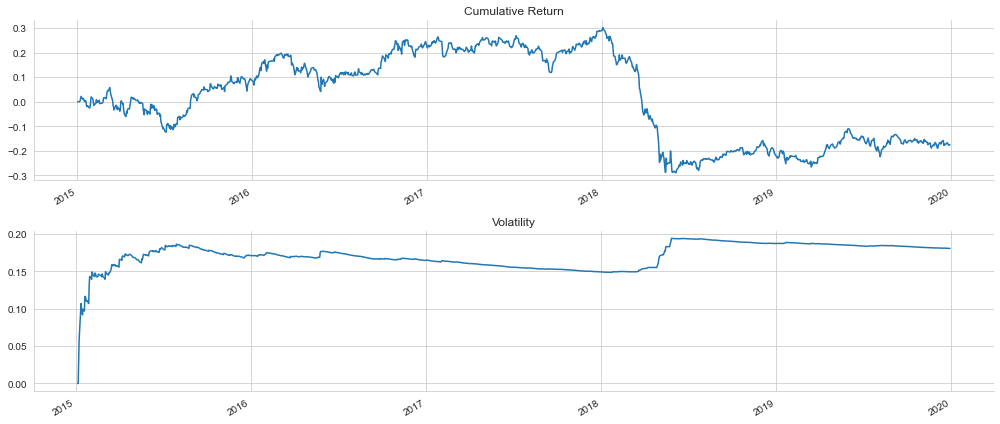

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(14,6))
result.algorithm_period_return.plot(ax=axes[0], title='Cumulative Return')
result.algo_volatility.plot(ax=axes[1], title='Volatility')
sns.despine()
fig.tight_layout();

## Pyfolio로 결과 분석

In [14]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [16]:
benchmark_period_returns = results['benchmark_period_return']

In [17]:
daily_benchmark_returns = np.exp(np.log(benchmark_period_returns + 1.0).diff()) - 1 

Start date,2015-01-02
End date,2019-12-30
Total months,58
,Backtest
Annual return,-3.874%
Cumulative returns,-17.5%
Annual volatility,18.078%
Sharpe ratio,-0.13
Calmar ratio,-0.09
Stability,0.29
Max drawdown,-45.433%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.43,2018-01-04,2018-06-05,NaT,NaN
1,17.23,2015-03-10,2015-07-06,2015-09-23,142
2,13.06,2016-03-02,2016-05-24,2016-10-17,164
3,11.79,2017-07-06,2017-09-15,2017-12-21,121
4,6.51,2017-01-24,2017-02-06,2017-07-06,118


Stress Events,mean,min,max
Fall2015,0.36%,-1.23%,3.31%
New Normal,-0.01%,-10.61%,7.97%


Top 10 long positions of all time,max
sid,
020560,7.68%
051630,5.75%
014910,5.56%
014130,5.45%
008970,5.35%
014990,5.28%
008040,5.24%
006090,5.21%
001420,5.19%


Top 10 short positions of all time,max
sid,
006490,-10.24%
009420,-8.56%
002210,-8.11%
004980,-8.03%
000520,-7.67%
003520,-7.35%
010770,-6.92%
007110,-6.92%
002310,-6.87%


Top 10 positions of all time,max
sid,
006490,10.24%
009420,8.56%
002210,8.11%
004980,8.03%
020560,7.68%
000520,7.67%
003520,7.35%
010770,6.92%
007110,6.92%


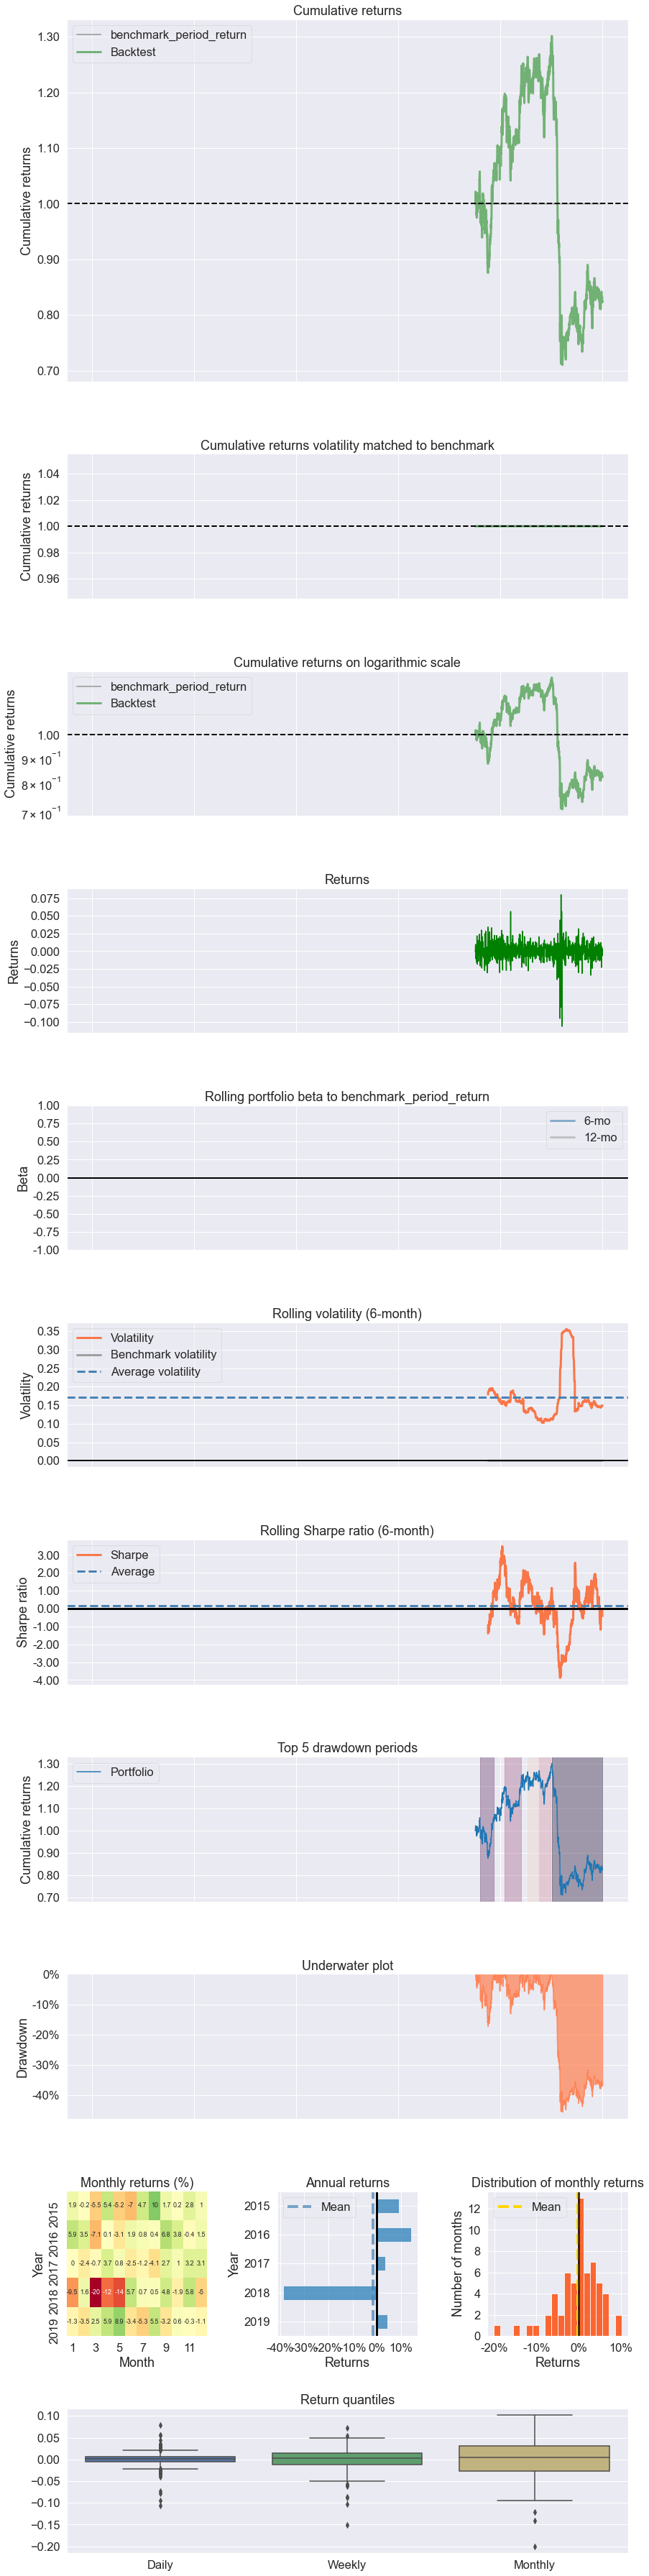

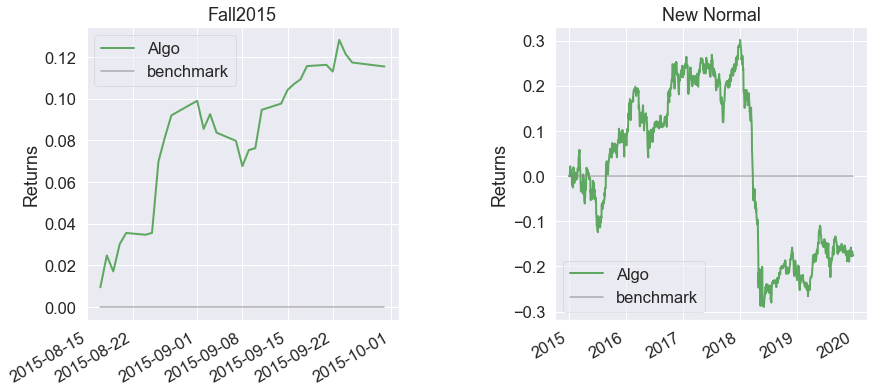

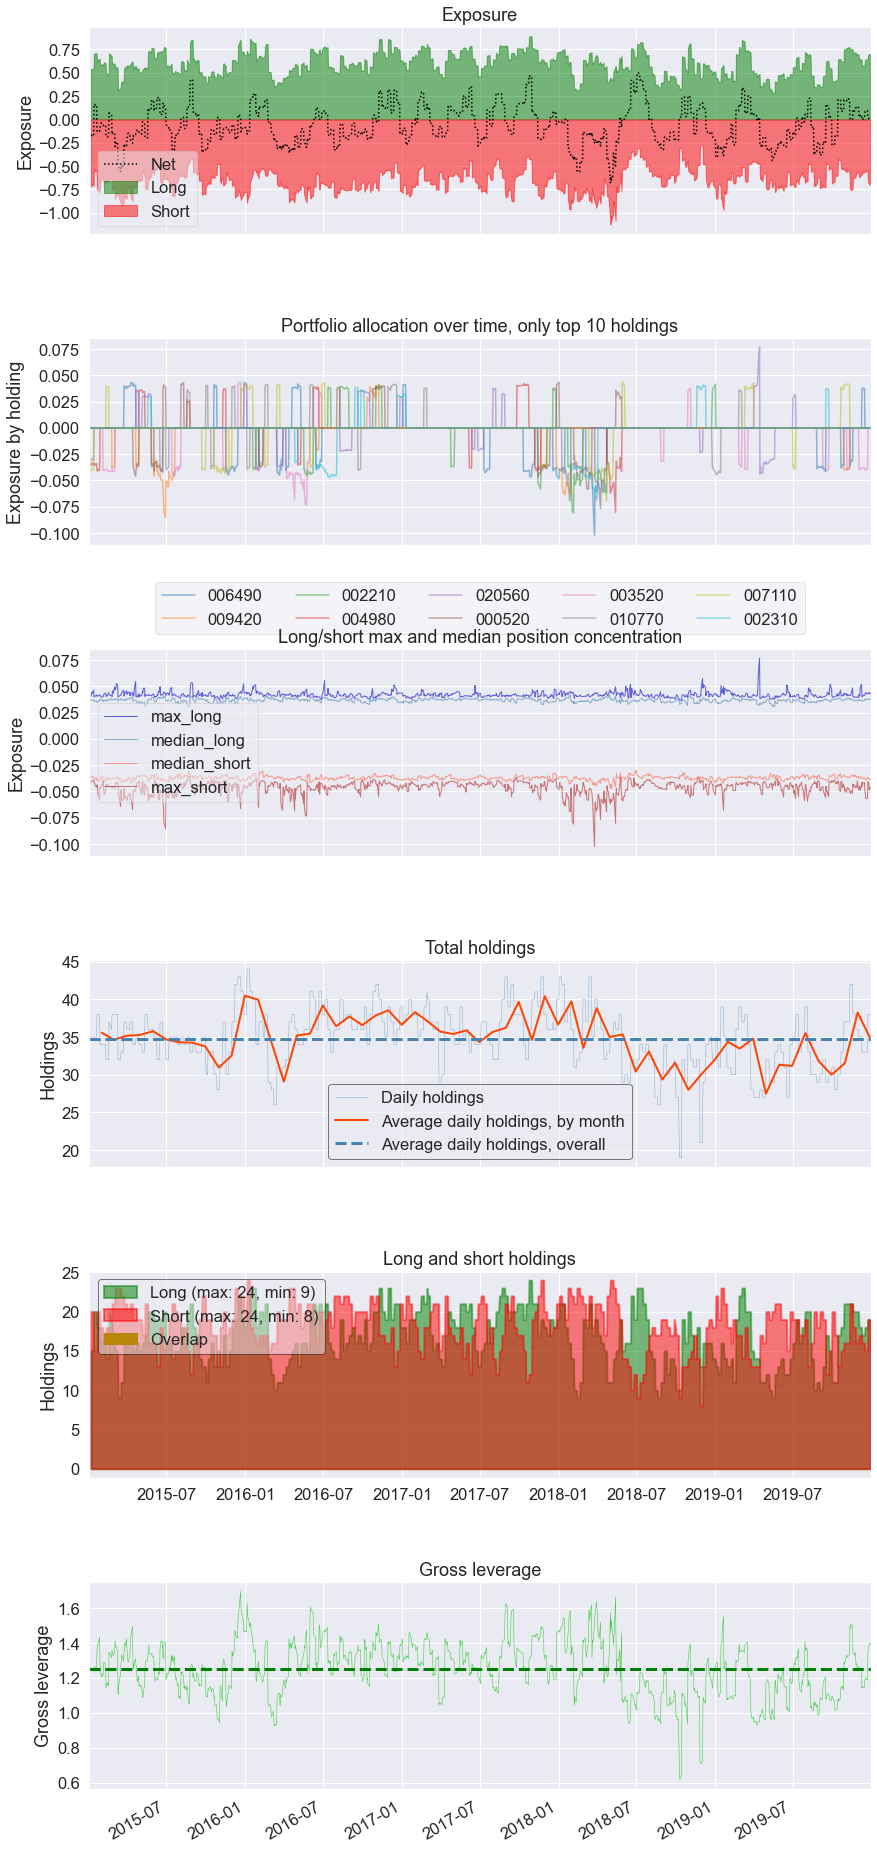

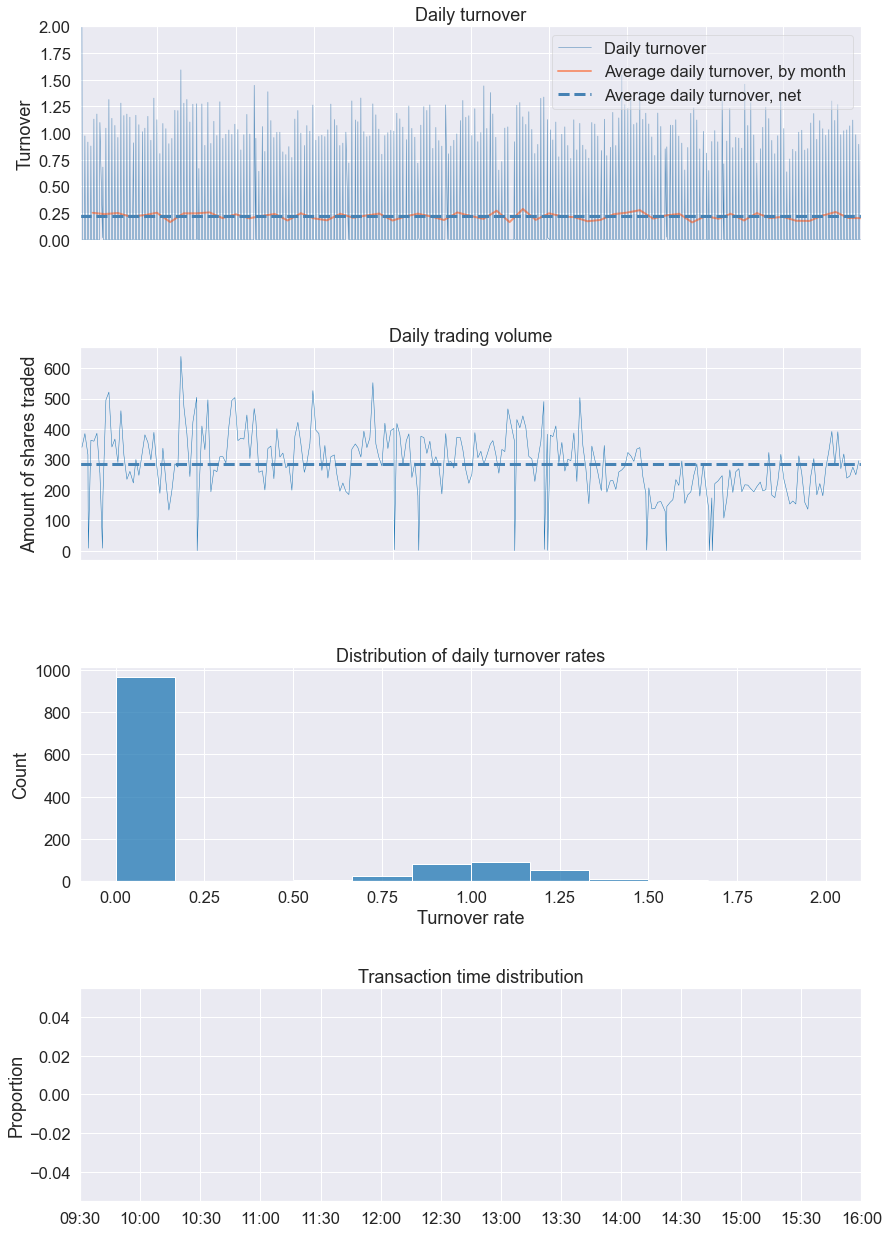

In [18]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)

## Pickle 파일로 BackTest 결과 저장

In [13]:
result

,period_open,period_close,returns,portfolio_value,longs_count,shorts_count,long_value,short_value,long_exposure,pnl,...,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,factor_data,prices
2015-01-02 06:30:00+00:00,2015-01-02 00:01:00+00:00,2015-01-02 06:30:00+00:00,0.000000,1.000000e+06,0,0,0.0,0.0,0.0,0.000000,...,NaN,NaN,0.000000,0.000000,0.0,0.0,1,2015-01,NaN,NaN
2015-01-05 06:30:00+00:00,2015-01-05 00:01:00+00:00,2015-01-05 06:30:00+00:00,0.000000,1.000000e+06,0,0,0.0,0.0,0.0,0.000000,...,NaN,NaN,0.000000,0.000000,0.0,0.0,2,2015-01,Equity(0 [001460]) 280.0 Equity(1 [001040...,Equity(0 [001460]) 260500.0 Equity(1 [001...
2015-01-06 06:30:00+00:00,2015-01-06 00:01:00+00:00,2015-01-06 06:30:00+00:00,-0.000003,9.999966e+05,15,20,541815.0,-719062.0,541815.0,-3.423681,...,-9.165151,-9.165151,-0.000003,1.260881,0.0,0.0,3,2015-01,Equity(0 [001460]) 280.0 Equity(1 [001040...,Equity(0 [001460]) 260500.0 Equity(1 [001...
2015-01-07 06:30:00+00:00,2015-01-07 00:01:00+00:00,2015-01-07 06:30:00+00:00,0.003568,1.003565e+06,15,20,541889.0,-715568.0,541889.0,3568.000000,...,7.927099,8263.924652,-0.000003,1.260881,0.0,0.0,4,2015-01,Equity(0 [001460]) 280.0 Equity(1 [001040...,Equity(0 [001460]) 260500.0 Equity(1 [001...
2015-01-08 06:30:00+00:00,2015-01-08 00:01:00+00:00,2015-01-08 06:30:00+00:00,0.008425,1.012020e+06,15,20,547599.0,-712823.0,547599.0,8455.000000,...,10.269195,24861.371113,-0.000003,1.260881,0.0,0.0,5,2015-01,Equity(0 [001460]) 280.0 Equity(1 [001040...,Equity(0 [001460]) 260500.0 Equity(1 [001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23 06:30:00+00:00,2019-12-23 00:01:00+00:00,2019-12-23 06:30:00+00:00,0.004016,8.268206e+05,18,15,531557.0,-451490.0,531557.0,3307.000000,...,-0.121871,-0.160648,-0.470073,1.759906,0.0,0.0,1223,2019-12,Equity(0 [001460]) 171.0 Equity(1 [001040...,Equity(0 [001460]) 234000.0 Equity(1 [001...
2019-12-24 06:30:00+00:00,2019-12-24 00:01:00+00:00,2019-12-24 06:30:00+00:00,0.004492,8.305347e+05,19,19,572195.0,-556550.0,572195.0,3714.024835,...,-0.116755,-0.153914,-0.470073,1.759906,0.0,0.0,1224,2019-12,Equity(0 [001460]) 171.0 Equity(1 [001040...,Equity(0 [001460]) 234000.0 Equity(1 [001...
2019-12-26 06:30:00+00:00,2019-12-26 00:01:00+00:00,2019-12-26 06:30:00+00:00,-0.006332,8.252757e+05,19,19,575511.0,-565125.0,575511.0,-5259.000000,...,-0.123820,-0.163213,-0.470073,1.759906,0.0,0.0,1225,2019-12,Equity(0 [001460]) 171.0 Equity(1 [001040...,Equity(0 [001460]) 234000.0 Equity(1 [001...
2019-12-27 06:30:00+00:00,2019-12-27 00:01:00+00:00,2019-12-27 06:30:00+00:00,-0.005946,8.203687e+05,19,19,576789.0,-571310.0,576789.0,-4907.000000,...,-0.130446,-0.171932,-0.470073,1.759906,0.0,0.0,1226,2019-12,Equity(0 [001460]) 171.0 Equity(1 [001040...,Equity(0 [001460]) 234000.0 Equity(1 [001...


In [14]:
result.to_pickle('single_factor.pickle')